<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


## Build a cube

This notebook demonstrates _ITSCube_ class which is used to generate time series of velocity pair granules for the region of interest which is defined by a polygon in target UTM projection.

### ITSCube:
1. Submits a query to the API to get a list of ITS_LIVE granules qualifying to be included into the cube.
   * Polygon UTM coordinates are converted to longitude/latitude coordinates in order for them to be passed to the API search query.
1. Accesses ITS_LIVE granules, which are stored in AWS S3 bucket, remotely without downloading them to the local storage.
1. Filters each ITS_LIVE granule by region of interest, and loads variables data only for the region.
1. Writes cube data (after processing 1000 granules at a time, which is a default setting for the ITSCube.NUM_GRANULES_TO_WRITE class attribute) to Zarr store to avoid out of memory failures.

The following logic is followed in qualifying the granule for inclusion into the data cube:
1. Ignores granules that don't contain valid data for the region of interest. It keeps track of a number of such ignored granules.
1. Ignores granules that are defined in other than target UTM projection. It keeps track of a number of such ignored granules.
1. In a case when multiple granules exist for the same middle date (middle date + time displacement as milliseconds), it picks the
   newest processed granule. This step is done based on the filename of each granule, so all duplicate granules are ignored before any read access to the S3 bucket. 

### ITSCube TODO
 * Interpolate polygon edges (lat/lon coordinates) to get better region inclusion when submitting granule query to the search API
 * Keep multiple granules for the same middle date if EPSG=3413

In [1]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Set up Dask diagnostics (optional for debugging)

In [2]:
# from dask.distributed import Client
# client = Client(processes=True, n_workers=8)
# client

#### Prepare parameters for the cube generation, including ITSLIVE API parameters to search for granules of interest

In [2]:
from itscube import ITSCube

# Create polygon as a square around the centroid in target '32628' UTM projection
# Projection for the polygon coordinates
projection = '32628'

# Centroid for the tile in target projection
c_x, c_y = (487462, 9016243)

# Offset in meters (1 pixel=240m): 100 km square (with offset=50km)
off = 50000 
polygon = ((c_x - off, c_y + off), (c_x + off, c_y + off), (c_x + off, c_y - off), (c_x - off, c_y - off), (c_x - off, c_y + off))
print(f"Polygon in UTM {projection}: {polygon}")

# Create cube object
cube = ITSCube(polygon, projection)

# Search API parameters
API_params = {
    'start'               : '2010-01-05',
    'end'                 : '2021-01-01',
    'percent_valid_pixels': 1
}

# Examine only first 100 granules - too slow to access S3 bucket locally
num_granules = 100

2021-03-17 10:24:56 - INFO - Polygon: ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))
2021-03-17 10:24:56 - INFO - Projection: 32628


Polygon in UTM 32628: ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))


2021-03-17 10:24:56 - INFO - Polygon's longitude/latitude coordinates: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


#### Create cube using remote access to S3 granules

In [11]:
# Write cube data to the local Zarr store for now
local_store = 'cube.zarr'

found_urls = cube.create(API_params, local_store, num_granules)

2021-03-17 10:51:26 - INFO - ITS_LIVE search API params: {'start': '2010-01-05', 'end': '2021-01-01', 'percent_valid_pixels': 1, 'polygon': '-18.853615384172965,81.6356820300733,-12.689367193215306,81.64763330453586,-12.91144647782456,80.75241792169454,-18.483852839771348,80.74163892715585,-18.853615384172965,81.6356820300733'}
2021-03-17 10:51:34 - INFO - Number of found by API granules: 55498 (took 8.215379405000022 seconds)
2021-03-17 10:51:34 - INFO - Examining only first 100 out of 55498 found granules
Skipping duplicate granules...:   0%|          | 0/100 [00:00<?, ?it/s]2021-03-17 10:51:34 - INFO - Skipping ['http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32627/LC08_L1TP_036243_20170724_20170724_01_RT_X_LC08_L1TP_036243_20160705_20170323_01_T1_G0240V01_P061.nc'] in favor of new http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32627/LC08_L1TP_036243_20170724_20170809_01_T1_X_LC08_L1TP_036243_20160705_201703

Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 24 (24.0%)
      double mid_date  : 14 (14.0%)
      wrong projections: [32627]


### Read cube data from the Zarr store

In [12]:
import xarray as xr

back_zarr = xr.open_zarr(local_store, decode_timedelta=False)
back_zarr

<xarray.Dataset>
Dimensions:                    (mid_date: 62, x: 417, y: 417)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2018-05-23T00:00:00....
  * x                          (x) float64 4.376e+05 4.379e+05 ... 5.375e+05
  * y                          (y) float64 9.066e+06 9.066e+06 ... 8.966e+06
Data variables:
    UTM_Projection             <U1 ...
    acquisition_img1           (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    acquisition_img2           (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    date_dt                    (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    flag_stable_shift          (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    interp_mask                (mid_date, y, x) float32 dask.array<chunksize=(16, 209, 209), meta=np.ndarray>
    map_scale_corrected        (mid_date) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    mission_img1               (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    mission_img2               (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    original_url_path          (mid_date) <U191 dask.array<chunksize=(62,), meta=np.ndarray>
    roi_valid_percentage       (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    satellite_img1             (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    satellite_img2             (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    sensor_img1                (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    sensor_img2                (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    stable_count               (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    v                          (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    v_error                    (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    va                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    va_error                   (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    va_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vp                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vp_error                   (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vr                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vr_error                   (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vr_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vx                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vx_error                   (mid_date) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    vx_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vxp                        (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vxp_error                  (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vxp_stable_shift           (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vy                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vy_error   

#### Create cube using remote access to S3 granules in parallel

In [13]:
parallel_local_store = 'cube_parallel.zarr'

p_cube = ITSCube(polygon, projection)
p_found_urls = p_cube.create_parallel(API_params, parallel_local_store, num_granules)

2021-03-17 10:52:59 - INFO - Polygon: ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))
2021-03-17 10:52:59 - INFO - Projection: 32628
2021-03-17 10:52:59 - INFO - Polygon's longitude/latitude coordinates: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
2021-03-17 10:52:59 - INFO - ITS_LIVE search API params: {'start': '2010-01-05', 'end': '2021-01-01', 'percent_valid_pixels': 1, 'polygon': '-18.853615384172965,81.6356820300733,-12.689367193215306,81.64763330453586,-12.91144647782456,80.75241792169454,-18.483852839771348,80.74163892715585,-18.853615384172965,81.6356820300733'}
2021-03-17 10:53:06 - INFO - Number of found by API granules: 55498 (took 6.6560693930000525 seconds)
2021-03-17 10:53:06 - INFO - Examining only first 100 out of 55498 found granules
Skipping duplicate granules...:   0%

[########################################] | 100% Completed | 26.3s


2021-03-17 10:53:32 - INFO - Combine 62 layers to the cube_parallel.zarr...
2021-03-17 10:53:35 - INFO - Combined 62 layers (took 2.647873749000155 seconds)
2021-03-17 10:53:35 - INFO - Encoding writing to Zarr: {'map_scale_corrected': {'_FillValue': 0.0, 'dtype': 'byte'}, 'interp_mask': {'_FillValue': 0.0, 'dtype': 'ubyte'}, 'chip_size_height': {'_FillValue': 0.0, 'dtype': 'ushort'}, 'chip_size_width': {'_FillValue': 0.0, 'dtype': 'ushort'}, 'flag_stable_shift': {'_FillValue': 0.0, 'dtype': 'long'}, 'v': {'_FillValue': -32767.0, 'dtype': 'short'}, 'vx': {'_FillValue': -32767.0, 'dtype': 'short'}, 'vx_error': {'_FillValue': -32767.0}, 'vx_stable_shift': {'_FillValue': -32767.0}, 'vy': {'_FillValue': -32767.0, 'dtype': 'short'}, 'vy_error': {'_FillValue': -32767.0}, 'vy_stable_shift': {'_FillValue': -32767.0}, 'va': {'_FillValue': -32767.0, 'dtype': 'short'}, 'va_error': {'_FillValue': -32767.0}, 'va_stable_shift': {'_FillValue': -32767.0}, 'vr': {'_FillValue': -32767.0, 'dtype': 'short

Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 24 (24.0%)
      double mid_date  : 14 (14.0%)
      wrong projections: [32627]


In [15]:
import xarray as xr

parallel_back_zarr = xr.open_zarr(parallel_local_store)
parallel_back_zarr

<xarray.Dataset>
Dimensions:                    (mid_date: 62, x: 417, y: 417)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2018-05-23T00:00:00....
  * x                          (x) float64 4.376e+05 4.379e+05 ... 5.375e+05
  * y                          (y) float64 9.066e+06 9.066e+06 ... 8.966e+06
Data variables:
    UTM_Projection             <U1 ...
    acquisition_img1           (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    acquisition_img2           (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    date_dt                    (mid_date) timedelta64[ns] dask.array<chunksize=(62,), meta=np.ndarray>
    flag_stable_shift          (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    interp_mask                (mid_date, y, x) float32 dask.array<chunksize=(16, 209, 209), meta=np.ndarray>
    map_scale_corrected        (mid_date) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    mission_img1               (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    mission_img2               (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    original_url_path          (mid_date) <U191 dask.array<chunksize=(62,), meta=np.ndarray>
    roi_valid_percentage       (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    satellite_img1             (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    satellite_img2             (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    sensor_img1                (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    sensor_img2                (mid_date) <U1 dask.array<chunksize=(62,), meta=np.ndarray>
    stable_count               (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    v                          (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    v_error                    (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    va                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    va_error                   (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    va_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vp                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vp_error                   (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vr                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vr_error                   (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vr_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vx                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vx_error                   (mid_date) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    vx_stable_shift            (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vxp                        (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vxp_error                  (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vxp_stable_shift           (mid_date) float64 dask.array<chunksize=(62,), meta=np.ndarray>
    vy                         (mid_date, y, x) float32 dask.array<chunksize=(16, 105, 209), meta=np.ndarray>
    vy_

### Display data of cube layers

#### Display first 10 of cube layers

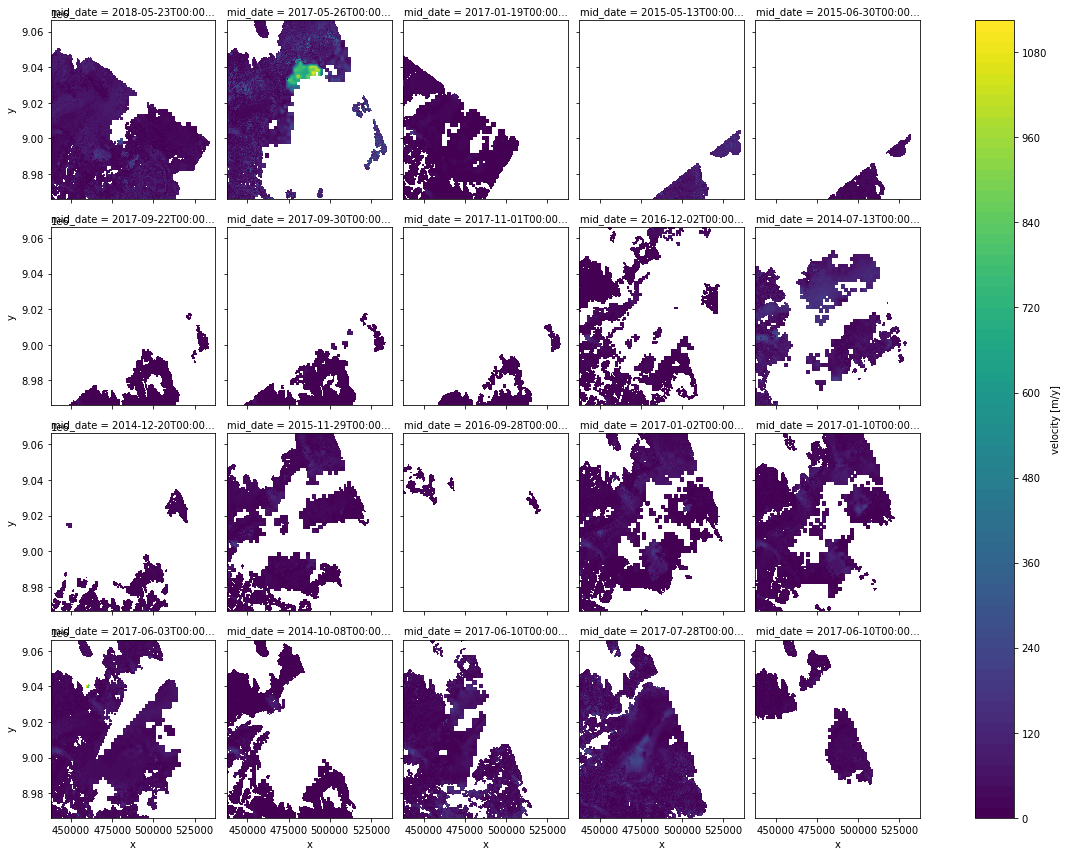

In [17]:
ITSCube.plot(back_zarr, 'v', (0, 20))

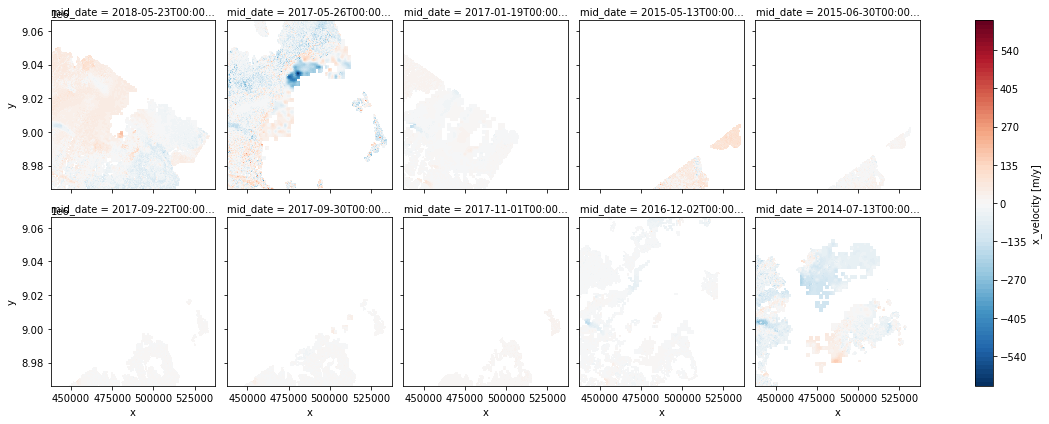

In [18]:
from itscube import ITSCube

ITSCube.plot(back_zarr, 'vx', (0, 10))

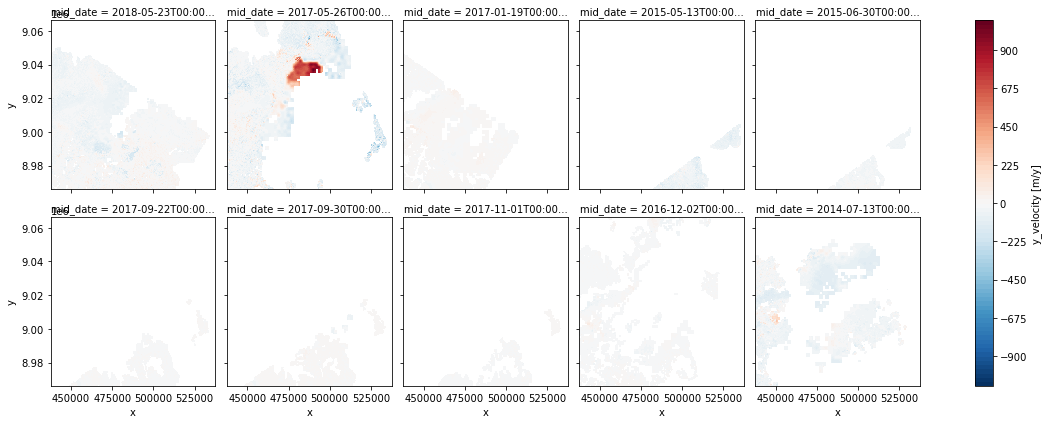

In [19]:
cube.plot(back_zarr, 'vy', (0, 10))

#### Display layers [40:50] of the cube

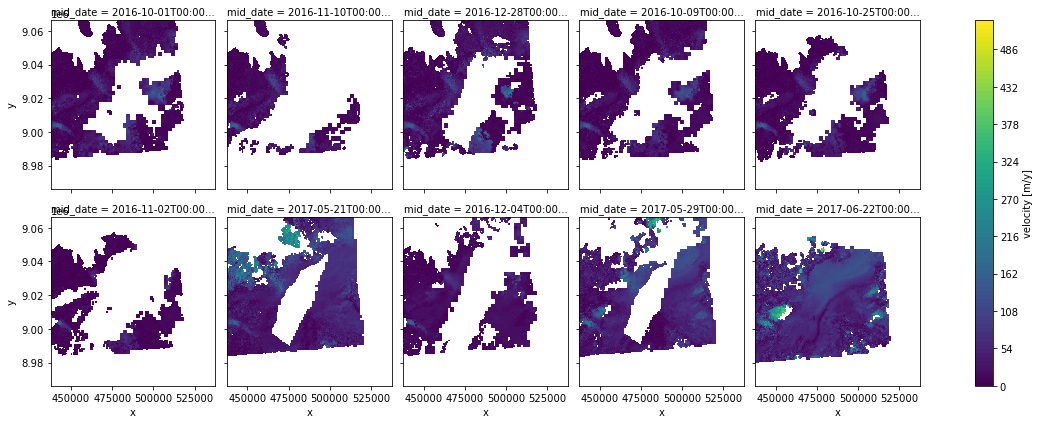

In [20]:
cube.plot(back_zarr, 'v', (40, 50))